In [40]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B,TNC
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 12345
np.random.seed(42)

## Hard core VQC

In [41]:
# Cross Entropy function.
def cross_entropy(y_pred, y_true):
 
    # computing softmax values for predicted values
    #y_pred = softmax(y_pred)
    loss = 0
     
    # Doing cross entropy Loss
    for i in range(len(y_pred)):
 
        # Here, the loss is computed using the
        # above mathematical formulation.
        loss = loss + (-1 * y_true[i]*np.log(y_pred[i]))
    # print(loss)
    return loss

In [42]:
# Use ad hoc data set for training and test data
from qiskit_machine_learning.datasets import ad_hoc_data
feature_dim = 2  # dimension of each data point
training_size = 20
test_size = 10

# training features, training labels, test features, test labels as np.ndarray,
# one hot encoding for labels
training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=training_size, test_size=test_size, n=feature_dim, gap=0.3
)

In [43]:
training_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

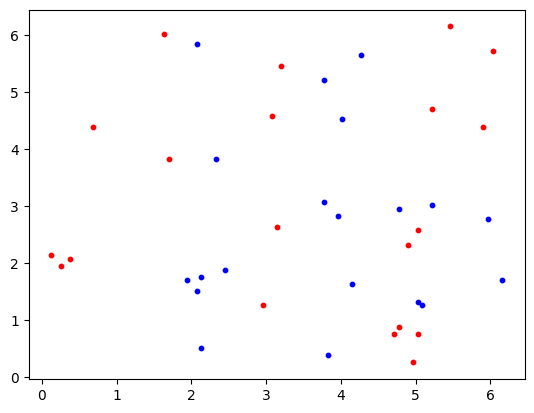

In [44]:
x1=[]
x2=[]
for i, v in enumerate(training_features):
    if training_labels[i][0]==1:
        x1.append(list(v))
    else:
        x2.append(list(v))
x1=np.array(x1)    
x2=np.array(x2) 
plt.scatter(x1[:,0],x1[:,1],s=10, c='b', marker="o", label='first')     
plt.scatter(x2[:,0],x2[:,1],s=10, c='r', marker="o", label='second') 
plt.show()
    

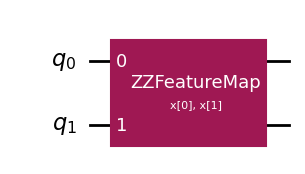

In [45]:
from qiskit.circuit.library import  TwoLocal, ZZFeatureMap,RealAmplitudes
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear") ## Choose feagture map
# ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
feature_map.draw('mpl')

In [46]:
# ansatz.draw('mpl')

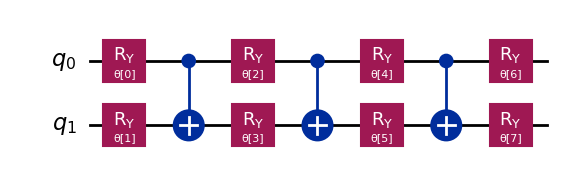

In [47]:
from qiskit.circuit.library import RealAmplitudes


ansatz = RealAmplitudes(num_qubits=feature_dim, reps=3)
ansatz.decompose().draw('mpl')

In [53]:
f_val=[]
itr=0
def cost_func(params, training_features, training_labels, sampler):
    """Return estimate of energy from sampler

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit

    Returns:
        float: Energy estimate
    """
    global f_val,itr
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear") ## Choose feagture map
    # ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
    ansatz = RealAmplitudes(num_qubits=feature_dim, reps=3)

    vqc_ckt = feature_map.compose(ansatz)

    loss=[]
    for i,x in enumerate(training_features):
        qc=vqc_ckt.copy()
        parameters=list(x)+list(params)
        qc.measure_all()
        job=sampler.run(qc,parameters)
        res=job.result().quasi_dists

        # Formate of output
        y_true=list(np. zeros(2**qc.num_qubits))
        if training_labels[i][0]==1:
            y_true[1]=1
        else:
            y_true[2]=1
        y_pred=list(res[0].values())

        #print(y_pred, y_true)
        loss.append(cross_entropy(y_pred, y_true))
        
    cost=sum(loss)/len(loss)
    f_val.append(cost)

    if itr%10==0:
        print('Iteration:',itr,'fun:',cost)
    itr=itr+1

    return cost

In [56]:
from qiskit.primitives import Estimator, Sampler
#estimator = Estimator()
sampler=Sampler()
x0 = np.random.rand(ansatz.num_parameters)  ## Initial value      #43
print(x0)
# x0=np.array ([0.45923317, 0.49371866, 0.57551473, 0.84051917, 0.25993984, 0.66425266,
#  0.16559752, 0.63738022, 0.93002718, 0.0168024  ,0.64698912 ,0.56321298,
#  0.3359864 , 0.62684042, 0.54548639, 0.03302976,])

# x0=np.array([ 0.54984404, -0.41036317,  0.20175046,  2.65439476,  0.39962775,
#         0.57569455,  2.40122922,  2.18254696,  3.31398097,  1.26346976,
#         0.42897529,  2.24253612, -0.59721792,  1.76331745,  1.14339952,
#         0.22966247])

[0.45606998 0.78517596 0.19967378 0.51423444 0.59241457 0.04645041
 0.60754485 0.17052412]


In [57]:
%%time
# SciPy minimizer routine
from scipy.optimize import minimize
opt = minimize(cost_func, x0, args=(training_features, training_labels, sampler), method="COBYLA", options={'disp': True, 'ftol':0.05, 'maxiter':150})



Iteration: 150 fun: 1.576831460173278
Iteration: 160 fun: 1.1702114821719038
Iteration: 170 fun: 0.9515267865362071
Iteration: 180 fun: 0.9340297362946087
Iteration: 190 fun: 0.90434277590722
Iteration: 200 fun: 0.8707433543767797
Iteration: 210 fun: 0.8043444953486801
Iteration: 220 fun: 0.7762891757883355
Iteration: 230 fun: 0.7687243022298645
Iteration: 240 fun: 0.7671106883150516
Iteration: 250 fun: 0.7668609774108012
Iteration: 260 fun: 0.7668590528510048
Iteration: 270 fun: 0.766844026021484
Iteration: 280 fun: 0.7668329455028889
Iteration: 290 fun: 0.7668321827829485
CPU times: user 18.6 s, sys: 1.19 s, total: 19.8 s
Wall time: 19.1 s

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  150   F = 7.668321E-01    MAXCV = 0.000000E+00
   X = 1.485953E-01   1.894889E+00   7.996730E-01   2.693256E-01   5.529635E-01
      -7.605416E-01   2.879943E-01  -1.372118E+00


In [234]:
#cost_func(x0, training_features, training_labels, sampler)

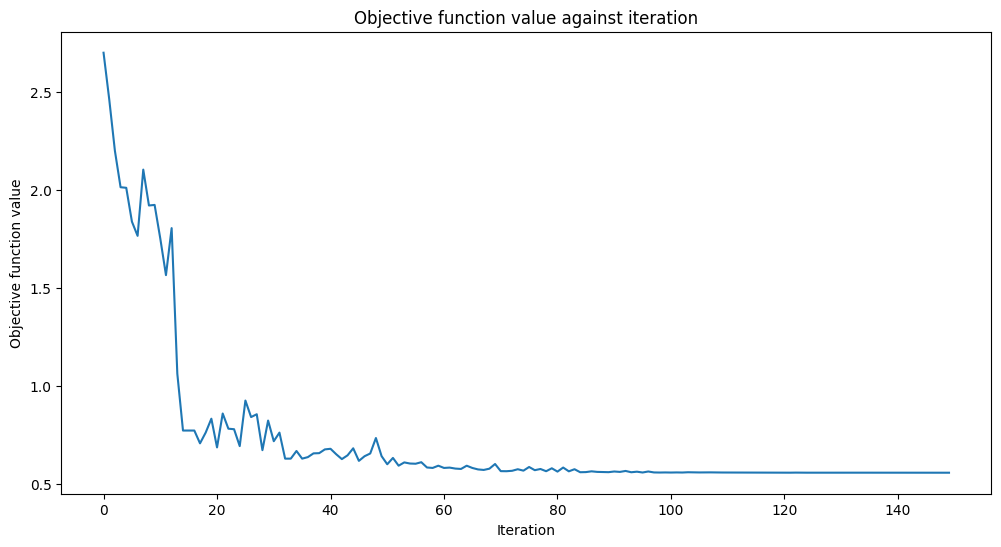

In [11]:

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(f_val)), f_val)
plt.show()


## Training data

In [12]:
para=list(opt.x)
lst=[]
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear") ## Choose feagture map
ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
vqc_ckt = feature_map.compose(ansatz)

for i in range(len(training_features)):
    qc=vqc_ckt.copy()
    parameters=list(training_features[i])+para
    qc.measure_all()
    job=sampler.run(qc,parameters)
    res=job.result().quasi_dists
    lst.append(res)

lb=[]
for i in lst:
    k=list(i[0].keys())
    v=list(i[0].values())
    lb.append(k[v.index(max(v))])
print(lb)
print(training_labels)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [13]:
bin(2)[2:]

'10'

## Testing data

In [14]:
para=list(opt.x)
lst=[]
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear") ## Choose feagture map
ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
vqc_ckt = feature_map.compose(ansatz)

for i in range(len(test_features)):
    qc=vqc_ckt.copy()
    parameters=list(test_features[i])+para
    qc.measure_all()
    job=sampler.run(qc,parameters)
    res=job.result().quasi_dists
    lst.append(res)

lb=[]
for i in lst:
    k=list(i[0].keys())
    v=list(i[0].values())
    lb.append(k[v.index(max(v))])
print(lb)
print(test_labels)

[1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
